In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display
import csv
from tempfile import NamedTemporaryFile
import shutil

# Our scripts
from corrections import *
from image import * 
from handling import *

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

### Read all files from the google bucket. Can cycle through the files in this list and write results to the csv file.

In [2]:
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

### Reanalyse and check the accuracy of the algorithm

In [3]:
ReanalysePredictions("../Data/Truth.csv", verbose=True)
correct_files, incorrect_files, invalid_files, character_confusions = \
    AccuracyCheck("/Users/jordan/Desktop/Guppies/Data/Truth.csv", verbose=False)

Reanalysed predictions

Number Correct: 728 
Number Incorrect: 223 
Number Invalid: 49
Attempted % Correct: 0.7655099894847529
Total % Correct: 0.728


### Opens a file from the google bucket (or locally), crops it, reads it and corrects the output.


Image has been read from google bucket.

Image has been cropped.

Initial label: MUL-1570-002/04/13 
Confidence: 0.7680219636438964

Removing special characters from the output string (e.g. '.', '|').
characters ( have been replaced with 1
characters \ have been replaced with 1
characters ( have been replaced with 1
characters \ have been replaced with 1
Character M is fine.
Character U is fine.
Character L is fine.
Character - is fine.
Character 1 is fine.
Character 5 is fine.
Character 7 is fine.
Character 0 is fine.
Character - is fine.
Character 0 is fine.
Character 0 is fine.
Character 2 is fine.
Character / is fine.
Character 0 is fine.
Character 4 is fine.
Character / is fine.
Character 1 is fine.
Character 3 is fine.

Preprocessing string.
String after preprocessing: ['MUL', '1570', '002/04/13']

Correct number of paragraphs.

Looking for errors in the title (MUL).
Final title: MUL

Looking for errors in the identity (1570).
Replacing erroneous number (5) with a matched altern

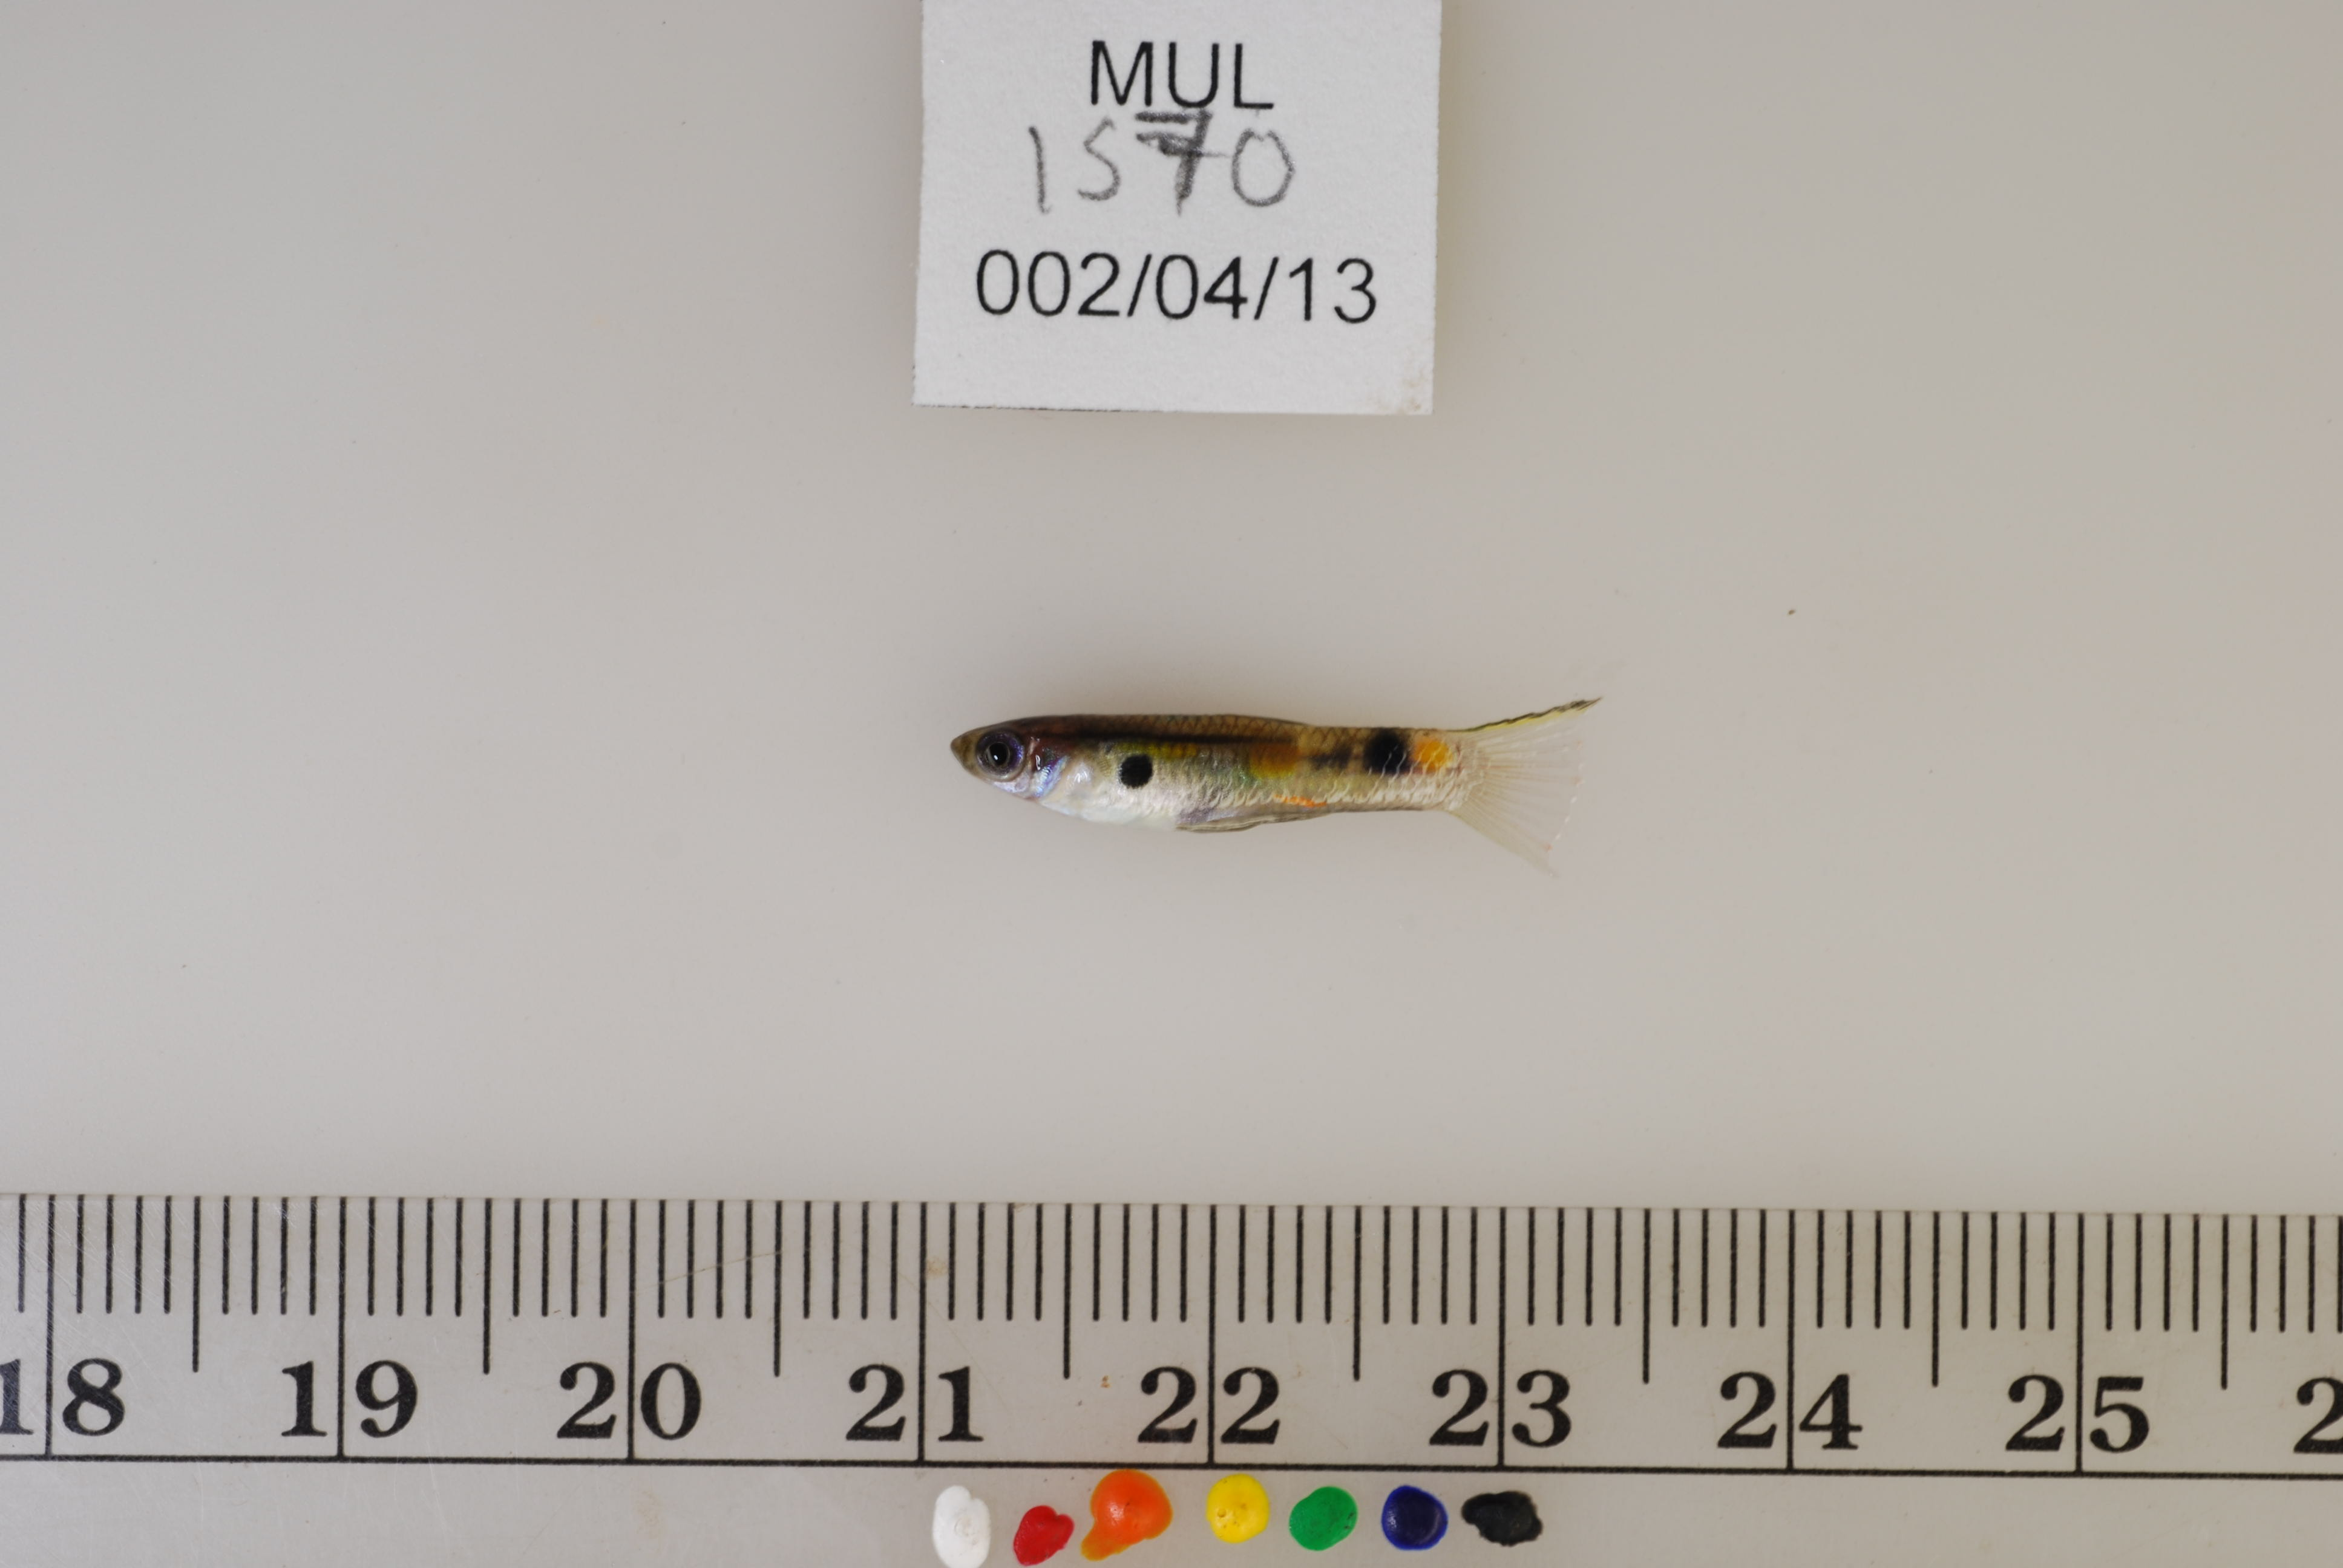

In [4]:
image, initial_label, corrected_label, word_confidences = \
    CorrectedLabel(correct_files[105], "remote", verbose=True)

Image.open(image)

### Make the confusion matrix

Text(0, 0.5, 'True Character')

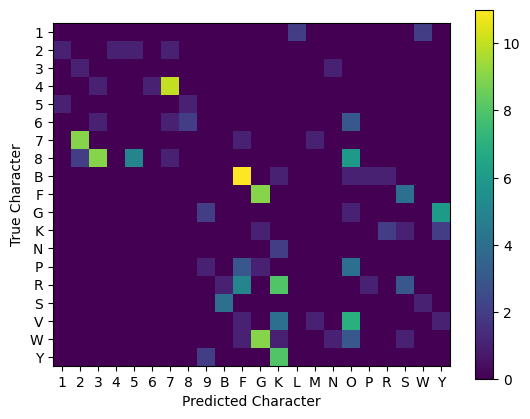

In [7]:
true_chars_unique, pred_chars_unique, confusion_matrix = \
    ConfusionMatrix(character_confusions)

import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.yticks(np.arange(len(true_chars_unique)), true_chars_unique)
plt.xticks(np.arange(len(pred_chars_unique)), pred_chars_unique)
plt.colorbar()
plt.xlabel("Predicted Character")
plt.ylabel("True Character")

### Only need character_confusions to recover the confusion matrix. Save character confusions to be read directly by the code.

In [9]:
np.save('../Data/character_confusions.npy', character_confusions)

In [2]:
"""List of new, manually labelled files that have been added. Currently just the 'CA1205' subset of these files are loaded, but can load all."""

new_files = []

client = storage.Client()
for blob in client.list_blobs('guppy_images', prefix='Manually_Labelled/CA1205'):
  new_files.append(blob.name)

In [8]:
file = new_files[200]
TruthFromFileName(file)

'MCA-2W8B-12/05'

In [18]:
"""Cycles through some of the newly added labels, compares them to the truth (only compares title and identity as the date is a bit dodge),
and does a simple check to see if we got it right. Currently, 81.3% attemped are right (ignoring dates) which is pretty nice."""

correct_files = []
incorrect_files = []
invalid_files = []


for file in new_files[:100]:
    image, initial_label, corrected_label, word_confidences = \
        CorrectedLabel(file, "remote", verbose=False)
    
    print("Truth label is: " + TruthFromFileName(file))
    
    if corrected_label == 1:
        invalid_files.append(file)

    else:
        if corrected_label.split("-")[0] == TruthFromFileName(file).split("-")[0] and corrected_label.split("-")[1] == TruthFromFileName(file).split("-")[1]:
            correct_files.append(file)
        else:
            incorrect_files.append(file)

print("Attempted % Correct:", len(correct_files) / (len(correct_files) + len(incorrect_files)))
print("Total % Correct:", len(correct_files) / (len(correct_files) + len(incorrect_files) + len(invalid_files)))


Initial label: FCA-IB3W-5/21/12 
Corrected label: FCA-1B3W-05/21/12
Truth label is: FCA-1B3W-12/05

Initial label: FCA-184-B-5/21/12 
Corrected label: FCA-1F4B-05/21/12
Truth label is: FCA-1B4B-12/05

Initial label: FCA-1-B4-K-5/21/12-K 
Corrected label: FCA-1B4K-05/21/12
Truth label is: FCA-1B4K-12/05

Initial label: FCA-X-*-IBGR-5/21/12 
Corrected label: FCA-1B6R-05/21/12
Truth label is: FCA-1B6R-12/05

Initial label: K-FCA-*-B6X-5/21/12 
Corrected label: 1
Truth label is: FCA-1B6Y-12/05

Initial label: FCA-IB7P-5/21/12 
Corrected label: FCA-1B7P-05/21/12
Truth label is: FCA-1B7P-12/05

Initial label: FCA-1640-5/21/12 
Corrected label: FCA-1G4O-05/21/12
Truth label is: FCA-1G4O-12/05

Initial label: FCA-IGGG-5/21/12 
Corrected label: FCA-1G6G-05/21/12
Truth label is: FCA-1G6G-12/05

Initial label: FCA-GEW-5/21/12 
Corrected label: 1
Truth label is: FCA-1G6W-12/05

Initial label: FCA-X-14-3R-5/21/12 
Corrected label: FCA-1Y3R-05/21/12
Truth label is: FCA-1K3R-12/05

Initial label: @-

### *Downloads*: Downloads images from the google bucket.

In [ ]:
correct_files, incorrect_files, invalid_files

for i, file in enumerate(incorrect_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/IncorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(error_files)))

for i, file in enumerate(correct_files[0:200]):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/CorrectImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))

for i, file in enumerate(invalid_files):
    # Initialise a client
    storage_client = storage.Client()
    # Create a bucket object for our bucket
    bucket = storage_client.get_bucket("guppy_images")
    # Create a blob object from the filepath
    blob = bucket.blob(file)
    # Download the file to a destination
    blob.download_to_filename('../Data/Images/InvalidImages/%s' %(file.replace("/", "-")))
    print("%i/%i" %(i+1, len(correct_subset)))

### *Interactive*: Write the filename, initial prediction, corrected prediction and the manually inputted truth to the truth.csv file for a set of file names.

In [ ]:
# Read all JPG files. All images are in both .jpg and .nef formats, need to avoid duplicates.
all_files = ListAvaliableFiles("guppy_images")
all_jpg_files = [ x for x in all_files if "JPG" in x ]

# Read the random number array we will use to assign images.
# random_array = np.arange(len(all_jpg_files))
# np.random.shuffle(random_array)
# np.save('../Data/radom_array.npy', random_array)
random_array = np.load('../Data/radom_array.npy')

# Assign images.
Jordan_array = random_array[0:500]
Sunny_array = random_array[500:1000]

Jordan_files = []
Sunny_files = []

for index in Jordan_array:
    Jordan_files.append(all_jpg_files[index])

for index in Sunny_array:
    Sunny_files.append(all_jpg_files[index])

In [ ]:
with open('../Data/truth.csv', 'a') as f:
    writer = csv.writer(f)

    for file in Sunny_files:
        # Read the data and predict the label.
        image = RetreiveImage(file, verbose=False)
        cropped_image = CroppedImage(image, verbose=False)

        display.display(Image.open(cropped_image))
        display.clear_output(wait=True)

        initial_prediction = ReadImage(cropped_image, verbose=False)[0]
        corrected_prediction = FindErrors(initial_prediction)
    
        # Provide truth
        truth = input("Truth:")

        writer.writerow([file, initial_prediction, corrected_prediction, truth])

### Code used to combine truth_sunny and truth_Jordan files.

In [ ]:
# files = ['../Data/truth_Jordan.csv', '../Data/truth_sunny.csv']

# whole_file = []

# for file in files:
#     with open(file, 'r') as f:
#         filereader = csv.reader(f)
#         for row in filereader:
#             if row != []:
#                 whole_file.append(row)


# with open('../Data/Truth.csv', 'w') as Truth:
#     writer = csv.writer(Truth)
#     for row in whole_file:
#         writer.writerow(row)